In [2]:
import pandas as pd
import numpy as np

dataset_train = pd.read_csv('trainee_train.csv', index_col=0)
# dataset_train.head()
dataset_test = pd.read_csv('trainee_test_fish.csv', index_col=0)

In [3]:
dataset_train.shape

(616, 447)

In [4]:
dataset_test.shape

(216, 446)

In [5]:
from collections import Counter
Counter(dataset_train["im"])

Counter({0.0: 174, 1.0: 442})

На train-е **сильный дисбаланс классов**: 174 к 442 (почти в 2.5 раза разница)
1. уменьшать данные второго класса приведет к потери большого количества информации
2. можно применить алгоритм устойчивый к дисбалансу классов (град бустинг, деревья или svd)

нейронки не имеет смысла применять тк мало данных

In [6]:
# Загрузка
X_train = dataset_train.drop("im", axis=1)
Y_train = dataset_train["im"] 
X_test = dataset_test

# Стандартизация
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Разделение на обучающую и валидационную
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Уменьшение мультиколлинеарности и оптимизация признаков

**Избыточное количество скоррелированных столбцов**:
1. можно удалить один из скоррелированных столбцов
2. добавить L1 регуляризрцию
3. применить PCA для уменьшения размерности
4. использовать "деревянные" модели для отбора признаков

In [7]:
class RemoveColumnsCorr():
    
    def __init__(self):
        self.corr_cols = []

    def fit(self, X, porog):
        corr_matrix = np.corrcoef(X, rowvar=False)
        self.corr_cols = []
        for i in range(corr_matrix.shape[0]):
            for j in range(i + 1, corr_matrix.shape[1]):
                if abs(corr_matrix[i][j]) > porog and j not in self.corr_cols:
                    self.corr_cols.append(j)
    
    def transform(self, X):
        return np.delete(X, self.corr_cols, axis=1)
    
# data = RemoveColumnsCorr()
# data.fit(X_train)
# data.transform(X_train).shape

In [8]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# pca = PCA(n_components=60)
# pca.fit(X_train)
# pca.transform(X_train).shape

In [9]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

class RemoveColumnsRF():
    
    def __init__(self):
        self.feature_importances = []
        self.porog = 0.004

    def fit(self, X, y):
        model = RandomForestClassifier()
        model.fit(X, y)
        self.feature_importances = model.feature_importances_
        # Отображение важности признаков
        # plt.figure(figsize=(10, 6))
        # plt.bar(range(len(feature_importances)), feature_importances, tick_label=feature_names)
        # plt.xlabel('Признаки')
        # plt.ylabel('Важность признака')
        # plt.title('Важность признаков с использованием RandomForest')
        # plt.xticks(rotation=45)
        # plt.show()
        
    def transform(self, X):
        indices = np.where(self.feature_importances > self.porog)[0]
        return X[:, indices]
    
# rcRF = RemoveColumnsRF()
# rcRF.fit(X_train, y_train)
# rcRF.transform(X_train).shape 

# Обучение

In [10]:
Corr = RemoveColumnsCorr()
Corr.fit(X_train, porog=0.5)

In [11]:
pca = PCA(n_components=60)
pca.fit(X_train)

PCA(n_components=60)

In [12]:
RF = RemoveColumnsRF()
RF.fit(X_train, y_train)

In [13]:
import xgboost as xgb
from sklearn.svm import SVC

from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def model_quality(y_val, y_pred): # Оценка модели
    # precision = precision_score(y_val, y_pred)
    # recall = recall_score(y_val, y_pred)
    # f1 = f1_score(y_val, y_pred)
    rocauc = roc_auc_score(y_val, y_pred)
    # print(f'Precision: {precision:.4f}')
    # print(f'Recall: {recall:.4f}')
    # print(f'F1-score: {f1:.4f}')
    return int(rocauc * 10000)

In [14]:
scale_pos_weight = len(y_train[y_train == 1]) / len(y_train[y_train == 0])

models = [xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric='logloss'),
          RandomForestClassifier(class_weight='balanced'), 
          SVC(kernel='linear', class_weight='balanced'),
          SVC(kernel='poly', class_weight='balanced'),
          SVC(kernel='rbf', class_weight='balanced'),
          SVC(kernel='sigmoid', class_weight='balanced')
         ]


In [15]:
result = np.zeros((3, len(models)))

for i, RemoveColumns in enumerate([Corr, pca, RF]):
    X_train_smaller = RemoveColumns.transform(X_train)
    X_val_smaller = RemoveColumns.transform(X_val)

    for j, model in enumerate(models):
        model.fit(X_train_smaller, y_train)
        y_pred = model.predict(X_val_smaller)
        result[i][j] = model_quality(y_val, y_pred)

In [16]:
df = pd.DataFrame(result, columns=['GradBoost', 'RF', 'SVC_linear', 'SVC_poly', 'SVC_rbf', 'SVC_sigmoid']) 
df.index = ['corr', 'pca', 'rf']
df[df > 8200]

,GradBoost,RF,SVC_linear,SVC_poly,SVC_rbf,SVC_sigmoid
corr,NaN,NaN,NaN,NaN,NaN,NaN
pca,NaN,NaN,8386.0,8493.0,9006.0,NaN
rf,8295.0,NaN,NaN,NaN,8493.0,NaN


Лучше всего себя показал метод опорных векторов при радиально-базисном функциональном (RBF) ядре 
при отбрасывании признаков с помощью PCA

Было бы правильнее использовать cross-validation для более честных ответов моделей, но не хватилло времени из-за поездки в Минск с 8 по 11 марта.

# Итоговая модель

In [17]:
# Загрузка
X_train = dataset_train.drop("im", axis=1)
y_train = dataset_train["im"] 
X_test = dataset_test

# Стандартизация
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Отбор признаков
pca = PCA(n_components=60)
pca.fit(X_train)
X_train_smaller = pca.transform(X_train)
X_test_smaller = pca.transform(X_test)

# Обучение
model = SVC(kernel='rbf', class_weight='balanced')
model.fit(X_train_smaller, y_train)

# Предстказание
y_pred = model.predict(X_test_smaller)

# Сохранение
df = pd.DataFrame(y_pred, columns=['y_pred'])
df.reset_index(inplace=True)
df.columns = ['', 'im']
df.to_csv('predictions.csv', index=False)

# А что если подстроиться под метрику

In [38]:
# Загрузка
X_train = dataset_train.drop("im", axis=1)
Y_train = dataset_train["im"] 
X_test = dataset_test

# Стандартизация
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Разделение на обучающую и валидационную
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Отбор признаков
pca = PCA(n_components=60)
pca.fit(X_train)
X_train_smaller = pca.transform(X_train)
X_val_smaller = pca.transform(X_val)
X_train_smaller.shape, X_val_smaller.shape

((492, 60), (124, 60))

In [46]:
# np.array(y_val)

In [39]:
# y_scores

In [40]:
# roc_curve(np.array(y_val), y_scores)

In [43]:
# clf.predict_proba(X_val_smaller)

In [44]:
from sklearn.metrics import roc_curve, auc
import numpy as np

# y_val
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_smaller, y_train)
y_scores = clf.predict_proba(X_val_smaller)[:, 1]  # Вероятности положительного класса

# Вычисляем FPR, TPR и пороги
fpr, tpr, thresholds = roc_curve(y_val, y_scores)
# Вычисляем AUC
roc_auc = auc(fpr, tpr)

# Находим оптимальный порог
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print(f"Оптимальный порог: {optimal_threshold:.2f}")

Оптимальный порог: 0.74


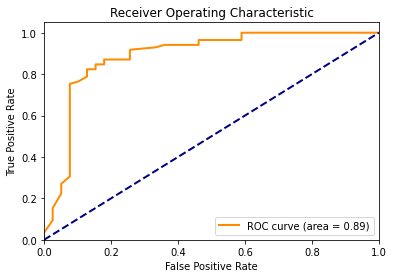

In [45]:
# Вычисление метрик для ROC кривой
fpr, tpr, thresholds = roc_curve(y_val, y_scores)

# Вычисление площади под ROC кривой (AUC)
roc_auc = auc(fpr, tpr)

# Построение ROC кривой
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()